#  SDCND: Deep Learning for Traffic Sign Recognition 

## Introduction 

**Note:** Where particular questions/answers are requested, they are filled in completely, even if this involves repetition of the information mentioned elsewhere in the notebook. This is to enable simpler evaluation. Note the bibliolgraphy at the end of the notebook. The rest of the notebook is meant to be read/flow normally from top to bottom. 

---
## Step 0: Load The Data

In [1]:
import numpy as np 
import pickle

training_file ='train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


### A helper method

In [2]:
# In case you were wondering why...I did most of my graduate work in R :-) 
# What a nice builtin method 'which' is... 
def which(bools_list): 
    return [i for i,val in enumerate(bools_list) if val]

---

## Step 1: Dataset Summary & Exploration  


In [3]:
n_train = len(y_train)
n_test = len(y_test)
image_shape = (X_train.shape[1], X_train.shape[2])
image_width = image_shape[1]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Image width =", image_width)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Image width = 32
Number of classes = 43


In [4]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.gridspec as pltgs

import cv2

%matplotlib inline

### Figure 1

Aside from establishing a working familiarity with the provided 
dataset, the objective of our visualization is to inform the structure of the neural 
network we will ultimately use.

This being the case, we begin with a mosaic of a randomly selected example from each 
of our 43 classes. It's simpler to just select one element explicitly, but if we mix it up like this, 
whenever we run the script, we might get some new insight by seeing an image we haven't seen before. We 
can't inspect every possible image, so this is one silly way of adressing 'the model-builder's bias.' 

For obvious reasons, including what was mentioned above, we only visualize examples 
in the training set. 

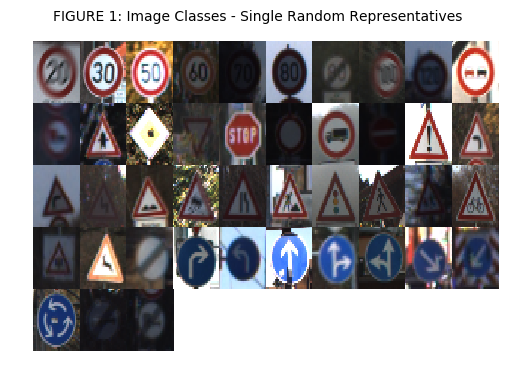

In [5]:
figure_1_images = list(map(lambda label: X_train[np.random.choice(which(y_train == label))], np.unique(y_train)))
figure_1_row_length = 10

figure_1 = plt.figure(1)
for i in range(0, len(figure_1_images)):
    figure_1_ax = figure_1.add_subplot(np.ceil(len(figure_1_images)/figure_1_row_length), figure_1_row_length, i+1)    
    figure_1_ax.imshow(figure_1_images[i], figure=figure_1, aspect='auto', interpolation='nearest')
    figure_1_ax.axis('off')
figure_1.subplots_adjust(wspace=0, hspace=0)
figure_1.suptitle('FIGURE 1: Image Classes - Single Random Representatives')


### Figure 2

Now, given that we have 43 classes (above) we visualize the distribution of these classes 
in our training dataset. A heavy class imbalance is self-evident, and will need to be 
accounted for in the model architecture below. 

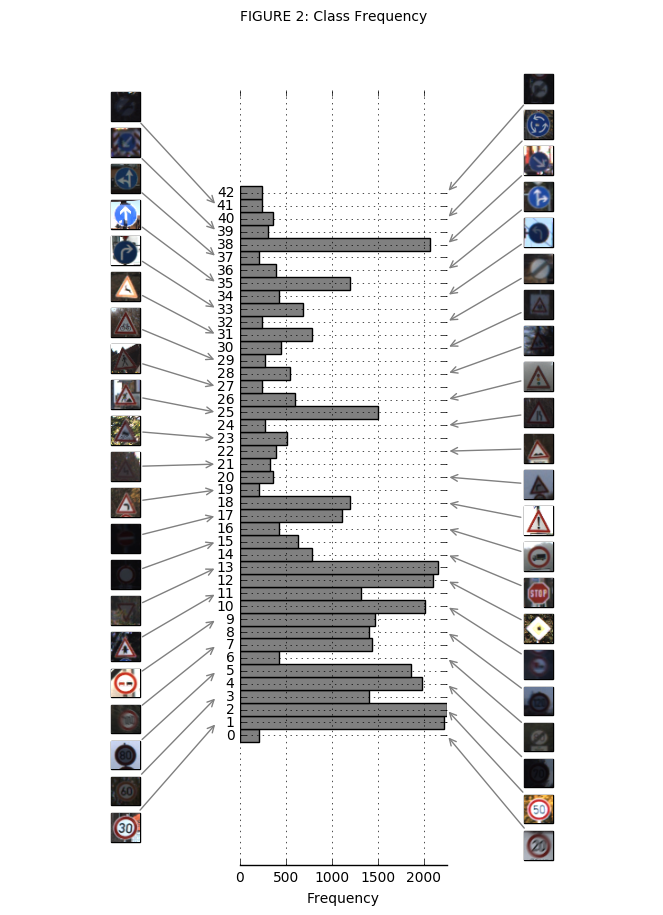

In [6]:
figure_2_labels,figure_2_freq = np.unique(y_train, return_counts=True)

figure_2_grid = pltgs.GridSpec(1,3)
figure_2 = plt.figure(2, figsize=(8,10))

figure_2_ax1 = figure_2.add_subplot(figure_2_grid[1])
figure_2_ax1.barh(figure_2_labels, figure_2_freq, 1, align='center', color='gray')
figure_2_ax1.grid(True)
figure_2_ax1.set_xlim([0,max(figure_2_freq)])

figure_2_ax1.spines['top'].set_visible(False)
figure_2_ax1.spines['right'].set_visible(False)
figure_2_ax1.spines['left'].set_visible(False)
plt.yticks(figure_2_labels, figure_2_labels, figure=figure_2)
plt.xlabel('Frequency')

# The coordinates of the thumbnails are computed in [0,60] and are then translated 
# down, so that they are centred w.r.t the left side of the figure. 
figure_2_thumbnail_coords_y = np.arange(0, 60, 60.0/len(figure_1_images))

figure_2_ax2 = figure_2.add_subplot(figure_2_grid[2],sharex=figure_2_ax1, sharey=figure_2_ax1)
for i in range(0, len(figure_1_images), 2):
    image_current  = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_2_ann = AnnotationBbox(image_current, 
                                 xybox=[1000, figure_2_thumbnail_coords_y[i]-(60-len(figure_1_images))/2],
                                 xycoords='data',
                                 xy=[0,i],
                                 arrowprops=dict(arrowstyle="->", color='gray'),
                                 pad=0)
    figure_2_ax2.add_artist(figure_2_ann)
    plt.axis('off') 

figure_2_ax3 = figure_2.add_subplot(figure_2_grid[0],sharex=figure_2_ax1, sharey=figure_2_ax1)
for i in range(1, len(figure_1_images), 2):
    image_current  = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_2_ann = AnnotationBbox(image_current, 
                                 xybox=[1000, figure_2_thumbnail_coords_y[i]-(60-len(figure_1_images))/2],
                                 xycoords='data',
                                 xy=[2000,i],
                                 arrowprops=dict(arrowstyle="->", color='gray'),
                                 pad=0)
    figure_2_ax3.add_artist(figure_2_ann)
    plt.axis('off') 

    
figure_2.subplots_adjust(wspace=0, hspace=0)                            
figure_2.suptitle('FIGURE 2: Class Frequency')


### Figure 3 

Below, examine the histograms of the random subset of images displayed in *Figure 1*. This demonstrates the extent of the contrast variation between the images in the training set. 

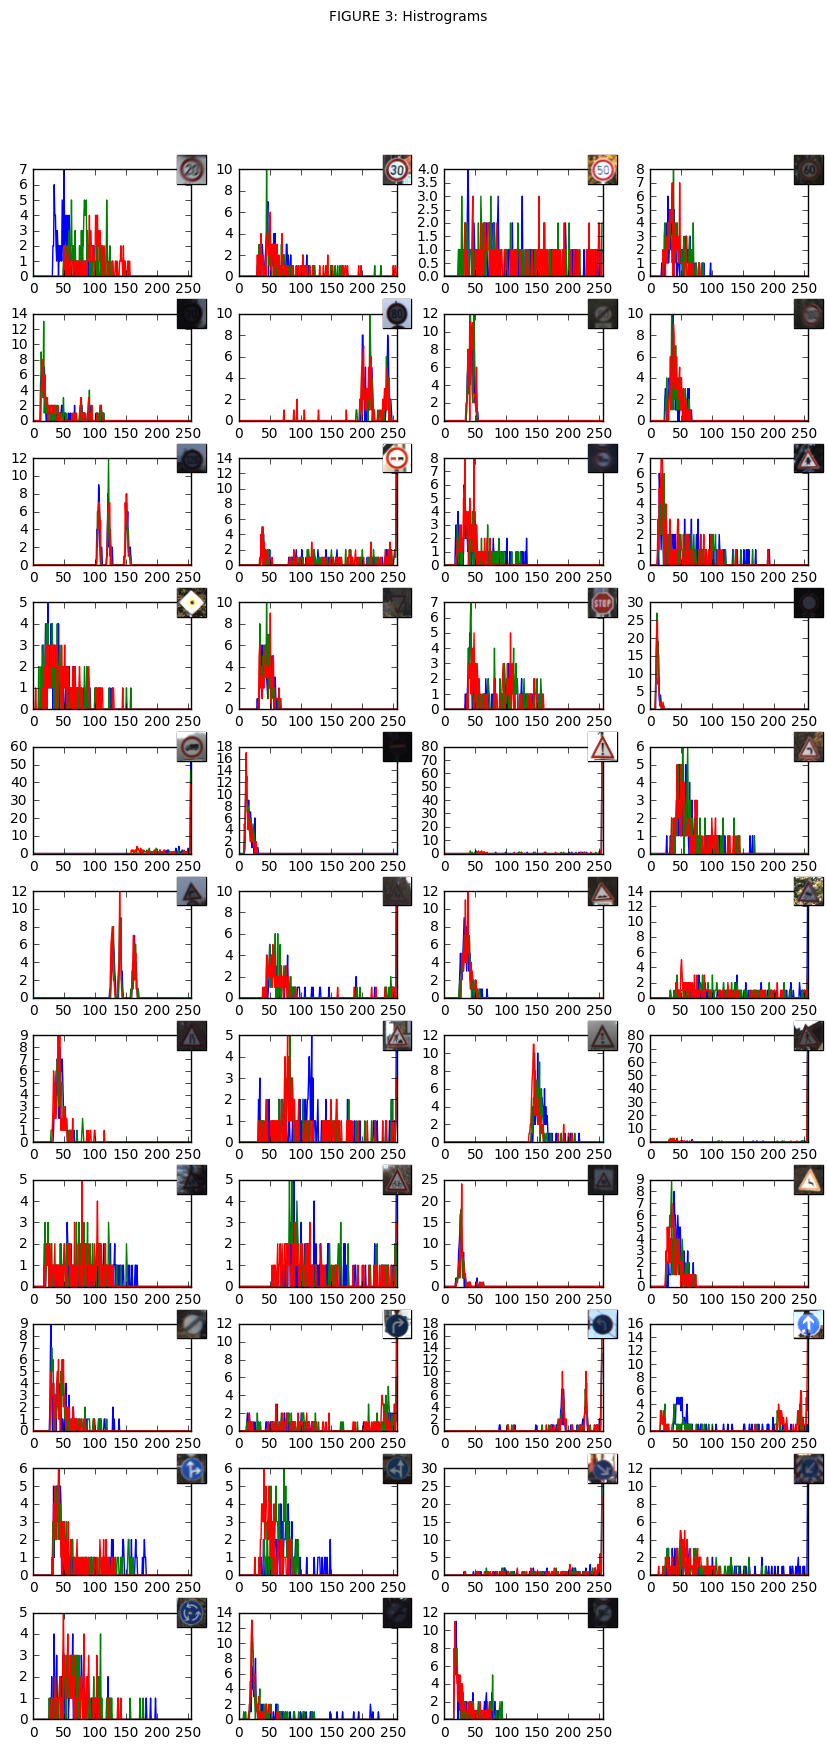

In [7]:
figure_3_row_length = 4

figure_3 = plt.figure(3, figsize=(10, 20))
for i in range(0, len(figure_1_images)):
    figure_3_ax = figure_3.add_subplot(np.ceil(len(figure_1_images)/figure_3_row_length), figure_3_row_length, i+1)
    for j,col in enumerate(('b', 'g', 'r')):
        figure_3_subhist = cv2.calcHist(figure_1_images[i], [j], None, [256], [0,256])
        figure_3_ax.plot(figure_3_subhist, color=col)
        figure_3_ax.set_xlim([0,256])
   
    # Give us a little thumbnail of the image to look at 
    image_current = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_3_ann = AnnotationBbox(image_current,
                                xybox=[1, 1],
                                xy=[1, 1],
                                xycoords='axes fraction',
                                pad=0)
    figure_3_ax.add_artist(figure_3_ann)
        
figure_3.subplots_adjust(wspace=0.3, hspace=0.35)
figure_3.suptitle('FIGURE 3: Histrograms')

As is evident in the figure above, histogram normalization will likely greatly aid model performance. 

----

## Step 2: Design and Test a Model Architecture


### Relevant Litterature 
The model and pre-processing phases are inspired by the published material cited in the bibliography at the tail of this notebook. 

### Helper Methods

In [8]:
# Imports
import tensorflow as tf 
import cv2

def clahe_RGB(img, clipLimit, tileGridSize): 
    """ Apply Contrast-Limited Adaptive Histogram Equalization with OpenCV
    
    Contrast-Limited Adaptive Histogram Equalization is applied to each 
    of the three color channels of an RGB image. The result is returned 
    as an RGB image. 
    
    Args:
        img: Input image, should be in RGB colorspace. 
        clipLimit: Passed to cv2.createCLAHE
        tileGridSize: Passed to cv2.createCLAHE
    
    Returns: 
        The input image, with CLAHE applied, in RGB
    """
    
    r,g,b = cv2.split(img)
    
    img_clahe   = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_clahe_r = img_clahe.apply(r)
    img_clahe_g = img_clahe.apply(g)
    img_clahe_b = img_clahe.apply(b)
    
    img_ret = cv2.merge((img_clahe_r, img_clahe_g, img_clahe_b))

    return(img_ret)

def jitter(img, deg_max=15, xy_max=2, scale_min=0.9, scale_max=1.1):
    """ Jitter an image, selecting parameters randomly within the specified range.
    
        Take in an RGB image, and, using openCV, randomly rotate, translate, and/or scale 
        the image according to the options specified by the user. OpenCV is used to apply 
        the transformations. If image pixels must be filled to maintain image dimensions, they 
        are given a value of 0. 
        
        Args: 
        
            img: RGB image 
            
            deg_max: Maximum number of degress by which we can rotate the image. Must be positive, 
            we can rotate in either counter clockwise, or clockwise. 
            
            xy_max: Minimum x/y values by which we can scale the image (must be positive, translation 
            may occur by +/- xy_max in either direction.)
            
            scale_min: Minimum allowed scaling (<= 1)
            scale_max: Maximum allowed scaling (>= 1)
        
        Returns: 
            An RGB color image with the translation applied. Image size remains the same, padding 
            with a pixel value of zero is added around the image. 
            
    """
    
    # Select parameters from the allowed ranges, for the transformation of this image.
    rn       = lambda xmax, xmin: np.random.uniform(xmin, xmax)
    rn_floor = lambda xmax, xmin: np.floor(np.random.uniform(xmin, xmax))
                
    img_h, img_w, _ = img.shape

    this_deg   = rn(-deg_max, deg_max)
    this_rotM  = cv2.getRotationMatrix2D((img_h/2, img_w/2), this_deg, 1)
    this_xy    = (rn_floor(-xy_max, xy_max), rn_floor(-xy_max, xy_max))
    this_scale = rn(scale_min, scale_max)
    
    # Transorm the image using OpenCV's geometric transformation machinery. 
    # Note that we're not using 'traditional' scaling here - we're sizing up the image and taking 
    # the size 'img' about the centre, or we're shrinking the image, and maitaining its dimensions 
    # with padding.     
    img_ret = cv2.warpAffine(img, M=np.float32([[1,0, this_xy[0]], [0,1,this_xy[1]]]), dsize=(img_w, img_h))
    img_ret = cv2.warpAffine(img_ret, M=this_rotM, dsize=(img_w, img_h))
    if this_scale <= 1: 
        new_h = int(np.floor(this_scale * img_h))
        new_w = int(np.floor(this_scale * img_w))
        img_ret = cv2.resize(img_ret, dsize=(new_w, new_h), interpolation=cv2.INTER_LINEAR)
        # Pad with 0s 
        img_ret = cv2.copyMakeBorder(img_ret, 
                                    top=(img_h - new_h), 
                                    bottom=(img_h - new_h), 
                                    left=(img_w - new_w), 
                                    right=(img_w - new_w),
                                    borderType=cv2.BORDER_CONSTANT, 
                                    value=[0,0,0,0])
    else:
        new_h = int(np.ceil(this_scale * img_h))
        new_w = int(np.ceil(this_scale * img_w))
        
        img_ret = cv2.resize(img_ret, dsize=(new_h, new_w), interpolation=cv2.INTER_LINEAR)
        diff_h = new_h - img_h
        diff_w = new_w - img_w
        img_ret = img_ret[diff_h:(diff_h+img_h), diff_w:(diff_w + img_w),:]

    img_ret = cv2.resize(img_ret, dsize=(img_h, img_w), interpolation=cv2.INTER_LINEAR)
    return img_ret 

    
           

### Dataset preparation and augmentation

Prior to the definition of a neural network architecture, we create separate datasets with various forms of pre-processing.

#### CLAHE
All methods cited above involve some degree of preprocessing. In particular, input images are generaly contrast-normalized in all approaches cited above **[1-6]**, and it is recommended in **[7]** as a means of removing unwanted variation in contrast between input images.  
While the authors in **[1]** opt for global contrast normalization, Ciresan et. al. opt for a local normalization method in **[2]**. 
In **[2]** the authors opt for contrast-limited adaptive histogram equalization (CLAHE) whereby normalization is applied in tiles across the image, and image is contrast is limited to avoid the amplification of noise. [The OpenCV documentation provides a  description of the procedure](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html). The neural network implemented by **[2]** also achieved heighest performance on images normalized with the CLAHE method. This being the case, CLAHE  is also applied here, and its effect may be visualized below, on the set of sample images in *Figure 1*.  

##### Figure 4
CLAHE applied to the set of sample images in *Figure 1*. Note the increased visibility of the road signs, particularly in darker images. The CLAHE procedure is applied with OpenCV, with a clipping limit of 1.0 and 4x4 tiles. 

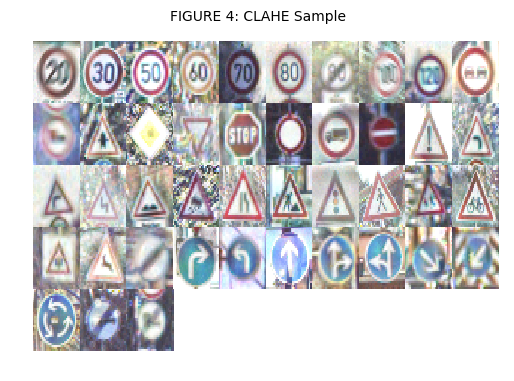

In [9]:
figure_4 = plt.figure(4)
for i in range(0, len(figure_1_images)):
    figure_4_ax = figure_4.add_subplot(np.ceil(len(figure_1_images)/figure_1_row_length), figure_1_row_length, i+1)
    img_clahe = clahe_RGB(figure_1_images[i], clipLimit=1.0, tileGridSize=(4,4))
    figure_4_ax.imshow(img_clahe, aspect='auto', interpolation='nearest')
    figure_4_ax.axis('off')
    
figure_4.subplots_adjust(wspace=0, hspace=0)
figure_4.suptitle('FIGURE 4: CLAHE Sample')


#### Jitter Augmentation 
In **[7]**, dataset augmentation is described as a useful means of generalizing a classifier. In **[1]**, Sermanet and LeCujn augment the traffic sign (training) datset with a "jittered dataset", formed by rotating, scaling, and translating the original images. The authors note that adding slightly 'deformed' versions of the input data will yield a more robust model. 

Here, a similar approach is adopted for the augmentation of the **training** (only, obviously) dataset. While the authors in **[1]** opted for a 5-fold augmentation of the original training set, for the sake of expediency, and to permit experimentation, we opt for only a 3-fold augmentation. 

An example of jitter, is visuazlized using the CLAHE processed training set, in *Figure 5*, below. The same translation, rotation, and scale range as **[1]** are used.

##### Figure 5 
Example of jitter, applied to the images depicted in *Figure 4*. The images are randomly rotated, translated, and scaled by a small amount. 

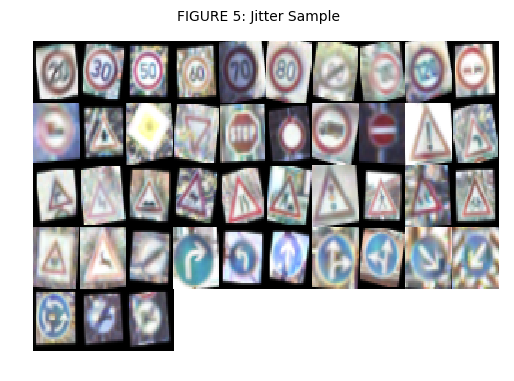

In [10]:
figure_5 = plt.figure(5)
for i in range(0, len(figure_1_images)):
    figure_5_ax = figure_5.add_subplot(np.ceil(len(figure_1_images)/figure_1_row_length), figure_1_row_length, i+1)
    img_jitter = jitter(clahe_RGB(figure_1_images[i], clipLimit=1.0, tileGridSize=(4,4)))
    figure_5_ax.imshow(img_jitter, aspect='auto', interpolation='nearest')
    figure_5_ax.axis('off')
    
figure_5.subplots_adjust(wspace=0, hspace=0)
figure_5.suptitle('FIGURE 5: Jitter Sample')

#### Datasets
This leaves us with the following datasets: 

1. Original training: X_train_orig
2. CLAHE training: X_train_clahe
3. Augmented training, no CLAHE): X_train_jitter
3. Augmented training, with CLAHE: X_train_jitter_clahe



### Model Architecture

In [12]:
# Constants
TF_EPOCHS = 20 
TF_BATCHS = 128

X_train_orig = X_train
y_train_orig = y_train 

# Local methods for applying our image transforms and encapsulating the parameters 
clahe_local = lambda image: clahe_RGB(image, clipLimit=1.0, tileGridSize=(4,4))
jitter_local = lambda image: jitter(image, deg_max=15, xy_max=2, scale_min=0.9, scale_max=1.1)

X_train_clahe = np.asarray([clahe_local(image) for image in X_train])

print(X_train_clahe.shape)




(39209, 32, 32, 3)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Bibliography 

**Note:** A number of the articles mentioned below are not open access. Until my official graduation from my M.Sc., I have institutional access. 

### Articles 
**[1]** Cireşan, D., U. Meier, J. Masci, and J. Schmidhuber. 2011. “A Committee of Neural Networks for Traffic Sign Classification.” In The 2011 International Joint Conference on Neural Networks, 1918–21.

**[2]** Sermanet, Pierre, and Yann LeCun. 2011. “Traffic Sign Recognition with Multi-Scale Convolutional Networks.” In Neural Networks (IJCNN), The 2011 International Joint Conference on, 2809–13.

**[3]** Ruta, Andrzej, Yongmin Li, and Xiaohui Liu. 2010/1. “Real-Time Traffic Sign Recognition from Video by Class-Specific Discriminative Features.” Pattern Recognition 43 (1): 416–30.

**[4]** Stallkamp, J., M. Schlipsing, J. Salmen, and C. Igel. 2012. “2012 Special Issue: Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition.” Neural Networks: The Official Journal of the International Neural Network Society 32 (August). Oxford, UK, UK: Elsevier Science Ltd.: 323–32.

**[5]** Escalera, A. de la, J. M. Armingol, and M. Mata. 2003. “Traffic Sign Recognition and Analysis for Intelligent Vehicles.” Image and Vision Computing 21 (3): 247–58.

**[6]** Maldonado-Bascon, S., S. Lafuente-Arroyo, P. Gil-Jimenez, H. Gomez-Moreno, and F. Lopez-Ferreras. 2007. “Road-Sign Detection and Recognition Based on Support Vector Machines.” IEEE Transactions on Intelligent Transportation Systems 8 (2): 264–78.

### Books
**[7]** Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. 2016. Deep Learning. MIT Press.